# PageRank
In this notebook, you'll build on your knowledge of eigenvectors and eigenvalues by exploring the PageRank algorithm.
The notebook is in two parts, the first is a worksheet to get you up to speed with how the algorithm works - here we will look at a micro-internet with fewer than 10 websites and see what it does and what can go wrong.
The second is an assessment which will test your application of eigentheory to this problem by writing code and calculating the page rank of a large network representing a sub-section of the internet.

## Part 1 - Worksheet
### Introduction

PageRank (developed by Larry Page and Sergey Brin) revolutionized web search by generating a
ranked list of web pages based on the underlying connectivity of the web. The PageRank algorithm is
based on an ideal random web surfer who, when reaching a page, goes to the next page by clicking on a
link. The surfer has equal probability of clicking any link on the page and, when reaching a page with no
links, has equal probability of moving to any other page by typing in its URL. In addition, the surfer may
occasionally choose to type in a random URL instead of following the links on a page. The PageRank is
the ranked order of the pages from the most to the least probable page the surfer will be viewing.


In [1]:
# Before we begin, let's load the libraries.
%pylab notebook
import numpy as np
import numpy.linalg as la
from readonly.PageRankFunctions import *
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


### PageRank as a linear algebra problem
Let's imagine a micro-internet, with just 6 websites (**A**vocado, **B**ullseye, **C**atBabel, **D**romeda, **e**Tings, and **F**aceSpace).
Each website links to some of the others, and this forms a network as shown,

![A Micro-Internet](readonly/internet.png "A Micro-Internet")

The design principle of PageRank is that important websites will be linked to by important websites.
This somewhat recursive principle will form the basis of our thinking.

Imagine we have 100 *Procrastinating Pat*s on our micro-internet, each viewing a single website at a time.
Each minute the Pats follow a link on their website to another site on the micro-internet.
After a while, the websites that are most linked to will have more Pats visiting them, and in the long run, each minute for every Pat that leaves a website, another will enter keeping the total numbers of Pats on each website constant.
The PageRank is simply the ranking of websites by how many Pats they have on them at the end of this process.

We represent the number of Pats on each website with the vector,
$$\mathbf{r} = \begin{bmatrix} r_A \\ r_B \\ r_C \\ r_D \\ r_E \\ r_F \end{bmatrix}$$
And say that the number of Pats on each website in minute $i+1$ is related to those at minute $i$ by the matrix transformation

$$ \mathbf{r}^{(i+1)} = L \,\mathbf{r}^{(i)}$$
with the matrix $L$ taking the form,
$$ L = \begin{bmatrix}
L_{A→A} & L_{B→A} & L_{C→A} & L_{D→A} & L_{E→A} & L_{F→A} \\
L_{A→B} & L_{B→B} & L_{C→B} & L_{D→B} & L_{E→B} & L_{F→B} \\
L_{A→C} & L_{B→C} & L_{C→C} & L_{D→C} & L_{E→C} & L_{F→C} \\
L_{A→D} & L_{B→D} & L_{C→D} & L_{D→D} & L_{E→D} & L_{F→D} \\
L_{A→E} & L_{B→E} & L_{C→E} & L_{D→E} & L_{E→E} & L_{F→E} \\
L_{A→F} & L_{B→F} & L_{C→F} & L_{D→F} & L_{E→F} & L_{F→F} \\
\end{bmatrix}
$$
where the columns represent the probability of leaving a website for any other website, and sum to one.
The rows determine how likely you are to enter a website from any other, though these need not add to one.
The long time behaviour of this system is when $ \mathbf{r}^{(i+1)} = \mathbf{r}^{(i)}$, so we'll drop the superscripts here, and that allows us to write,
$$ L \,\mathbf{r} = \mathbf{r}$$

which is an eigenvalue equation for the matrix $L$, with eigenvalue 1 (this is guaranteed by the probabalistic structure of the matrix $L$).

Complete the matrix $L$ below, we've left out the column for which websites the *FaceSpace* website (F) links to.
Remember, this is the probability to click on another website from this one, so each column should add to one (by scaling by the number of links).

In [2]:
# Replace the ??? here with the probability of clicking a link to each website when leaving Website F (FaceSpace).
L = np.array([[0,   1/2, 1/3, 0, 0,   0 ],
              [1/3, 0,   0,   0, 1/2, 0 ],
              [1/3, 1/2, 0,   1, 0,   1/2 ],
              [1/3, 0,   1/3, 0, 1/2, 1/2 ],
              [0,   0,   0,   0, 0,   0 ],
              [0,   0,   1/3, 0, 0,   0 ]])

In principle, we could use a linear algebra library, as below, to calculate the eigenvalues and vectors.
And this would work for a small system. But this gets unmanagable for large systems.
And since we only care about the principal eigenvector (the one with the largest eigenvalue, which will be 1 in this case), we can use the *power iteration method* which will scale better, and is faster for large systems.

Use the code below to peek at the PageRank for this micro-internet.

In [3]:
eVals, eVecs = la.eig(L) # Gets the eigenvalues and vectors
order = np.absolute(eVals).argsort()[::-1] # Orders them by their eigenvalues
eVals = eVals[order]
eVecs = eVecs[:,order]

r = eVecs[:, 0] # Sets r to be the principal eigenvector
100 * np.real(r / np.sum(r)) # Make this eigenvector sum to one, then multiply by 100 Procrastinating Pats

array([ 16.        ,   5.33333333,  40.        ,  25.33333333,
         0.        ,  13.33333333])

We can see from this list, the number of Procrastinating Pats that we expect to find on each website after long times.
Putting them in order of *popularity* (based on this metric), the PageRank of this micro-internet is:

**C**atBabel, **D**romeda, **A**vocado, **F**aceSpace, **B**ullseye, **e**Tings

Referring back to the micro-internet diagram, is this what you would have expected?
Convince yourself that based on which pages seem important given which others link to them, that this is a sensible ranking.

Let's now try to get the same result using the Power-Iteration method that was covered in the video.
This method will be much better at dealing with large systems.

First let's set up our initial vector, $\mathbf{r}^{(0)}$, so that we have our 100 Procrastinating Pats equally distributed on each of our 6 websites.

In [4]:
r = 100 * np.ones(6) / 6 # Sets up this vector (6 entries of 1/6 × 100 each)
r # Shows it's value

array([ 16.66666667,  16.66666667,  16.66666667,  16.66666667,
        16.66666667,  16.66666667])

Next, let's update the vector to the next minute, with the matrix $L$.
Run the following cell multiple times, until the answer stabilises.

In [23]:
r = L @ r # Apply matrix L to r
r # Show it's value
# Re-run this cell multiple times to converge to the correct answer.

array([ 16.        ,   5.33333333,  40.        ,  25.33333333,
         0.        ,  13.33333333])

We can automate applying this matrix multiple times as follows,

In [24]:
r = 100 * np.ones(6) / 6 # Sets up this vector (6 entries of 1/6 × 100 each)
for i in np.arange(100) : # Repeat 100 times
    r = L @ r
r

array([ 16.        ,   5.33333333,  40.        ,  25.33333333,
         0.        ,  13.33333333])

Or even better, we can keep running until we get to the required tolerance.

In [27]:
r = 100 * np.ones(6) / 6 # Sets up this vector (6 entries of 1/6 × 100 each)
lastR = r
r = L @ r
i = 0
while la.norm(lastR - r) > 0.0001 :
    lastR = r
    r = L @ r
    i += 1
print(str(i) + " iterations to convergence.")
r

27 iterations to convergence.


array([ 15.99999654,   5.33332932,  40.00003127,  25.33332012,
         0.        ,  13.33332275])

See how the PageRank order is established fairly quickly, and the vector converges on the value we calculated earlier after a few tens of repeats.

Congratulations! You've just calculated your first PageRank!

### Damping Parameter
The system we just studied converged fairly quickly to the correct answer.
Let's consider an extension to our micro-internet where things start to go wrong.

Say a new website is added to the micro-internet: *Geoff's* Website.
This website is linked to by *FaceSpace* and only links to itself.
![An Expanded Micro-Internet](readonly/internet2.png "An Expanded Micro-Internet")

Intuitively, only *FaceSpace*, which is in the bottom half of the page rank, links to this website amongst the two others it links to,
so we might expect *Geoff's* site to have a correspondingly low PageRank score.

Build the new $L$ matrix for the expanded micro-internet, and use Power-Iteration on the Procrastinating Pat vector.
See what happens…

In [29]:
 # We'll call this one L2, to distinguish it from the previous L.
L2 = np.array([[0,   1/2, 1/3, 0, 0,   0, 0 ],
               [1/3, 0,   0,   0, 1/2, 0, 0 ],
               [1/3, 1/2, 0,   1, 0,   1/3, 0 ],
               [1/3, 0,   1/3, 0, 1/2, 1/3, 0 ],
               [0,   0,   0,   0, 0,   0, 0 ],
               [0,   0,   1/3, 0, 0,   0, 0 ],
               [0,   0,   0,   0, 0,   1/3, 1 ]])

In [30]:
r = 100 * np.ones(7) / 7 # Sets up this vector (6 entries of 1/6 × 100 each)
lastR = r
r = L2 @ r
i = 0
while la.norm(lastR - r) > 0.01 :
    lastR = r
    r = L2 @ r
    i += 1
print(str(i) + " iterations to convergence.")
r

131 iterations to convergence.


array([  0.03046998,   0.01064323,   0.07126612,   0.04423198,
         0.        ,   0.02489342,  99.81849527])

That's no good! *Geoff* seems to be taking all the traffic on the micro-internet, and somehow coming at the top of the PageRank.
This behaviour can be understood, because once a Pat get's to *Geoff's* Website, they can't leave, as all links head back to Geoff.

To combat this, we can add a small probability that the Procrastinating Pats don't follow any link on a webpage, but instead visit a website on the micro-internet at random.
We'll say the probability of them following a link is $d$ and the probability of choosing a random website is therefore $1-d$.
We can use a new matrix to work out where the Pat's visit each minute.
$$ M = d \, L + \frac{1-d}{n} \, J $$
where $J$ is an $n\times n$ matrix where every element is one.

If $d$ is one, we have the case we had previously, whereas if $d$ is zero, we will always visit a random webpage and therefore all webpages will be equally likely and equally ranked.
For this extension to work best, $1-d$ should be somewhat small - though we won't go into a discussion about exactly how small.

Let's retry this PageRank with this extension.

In [35]:
d = 0.9 # Feel free to play with this parameter after running the code once.
M = d * L2 + (1-d)/7 * np.ones([7, 7]) # np.ones() is the J matrix, with ones for each entry.

In [58]:
r = 100 * np.ones(7) / 7 # Sets up this vector (6 entries of 1/6 × 100 each)
lastR = r
r = M @ r
i = 0
while la.norm(lastR - r) > 0.0001 :
    lastR = r
    r = M @ r
    i += 1
print(str(i) + " iterations to convergence.")
r

70 iterations to convergence.


array([ 10.40839841,   5.19395238,  22.14178711,  14.25783733,
         1.42857143,   8.07111759,  38.49833574])

This is certainly better, the PageRank gives sensible numbers for the Procrastinating Pats that end up on each webpage.
This method still predicts Geoff has a high ranking webpage however.
This could be seen as a consequence of using a small network. We could also get around the problem by not counting self-links when producing the L matrix (an if a website has no outgoing links, make it link to all websites equally).
We won't look further down this route, as this is in the realm of improvements to PageRank, rather than eigenproblems.

You are now in a good position, having gained an understanding of PageRank, to produce your own code to calculate the PageRank of a website with thousands of entries.

Good Luck!

## Part 2 - Assessment
In this assessment, you will be asked to produce a function that can calculate the PageRank for an arbitrarily large probability matrix.
This, the final assignment of the course, will give less guidance than previous assessments.
You will be expected to utilise code from earlier in the worksheet and re-purpose it to your needs.

### How to submit
Edit the code in the cell below to complete the assignment.
Once you are finished and happy with it, press the *Submit Assignment* button at the top of this notebook.

Please don't change any of the function names, as these will be checked by the grading script.

If you have further questions about submissions or programming assignments, here is a [list](https://www.coursera.org/learn/linear-algebra-machine-learning/discussions/weeks/1/threads/jB4klkn5EeibtBIQyzFmQg) of Q&A. You can also raise an issue on the discussion forum. Good luck!

In [38]:
# PACKAGE
# Here are the imports again, just in case you need them.
# There is no need to edit or submit this cell.
import numpy as np
import numpy.linalg as la
from readonly.PageRankFunctions import *
np.set_printoptions(suppress=True)

In [52]:
# GRADED FUNCTION
# Complete this function to provide the PageRank for an arbitrarily sized internet.
# I.e. the principal eigenvector of the damped system, using the power iteration method.
# (Normalisation doesn't matter here)
# The functions inputs are the linkMatrix, and d the damping parameter - as defined in this worksheet.
# (The damping parameter, d, will be set by the function - no need to set this yourself.)
def pageRank(linkMatrix, d) :
    n = linkMatrix.shape[0]
    M = d * linkMatrix + (1-d)/n * np.ones([n, n]) # np.ones() is the J matrix, with ones for each entry.
    r = n * np.ones(n) / n # Sets up this vector (6 entries of 1/6 × 100 each)
    lastR = r
    r = M @ r
    i = 0
    while la.norm(lastR - r) > 0.0001 :
        lastR = r
        r = M @ r
        i += 1
    return r


## Test your code before submission
To test the code you've written above, run the cell (select the cell above, then press the play button [ ▶| ] or press shift-enter).
You can then use the code below to test out your function.
You don't need to submit this cell; you can edit and run it as much as you like.

In [53]:
# Use the following function to generate internets of different sizes.
generate_internet(5)

array([[ 1. ,  0.2,  0.2,  0. ,  0. ],
       [ 0. ,  0.2,  0.2,  0. ,  0. ],
       [ 0. ,  0.2,  0.2,  1. ,  0. ],
       [ 0. ,  0.2,  0.2,  0. ,  0. ],
       [ 0. ,  0.2,  0.2,  0. ,  1. ]])

In [54]:
# Test your PageRank method against the built in "eig" method.
# You should see yours is a lot faster for large internets
L = generate_internet(10)

In [55]:
pageRank(L, 1)

array([ 3.05734306,  0.76433322,  1.08278834,  1.40127355,  0.57324938,
        0.38216318,  1.40127355,  0.38216318,  0.57324938,  0.38216318])

In [56]:
# Do note, this is calculating the eigenvalues of the link matrix, L,
# without any damping. It may give different results that your pageRank function.
# If you wish, you could modify this cell to include damping.
# (There is no credit for this though)
eVals, eVecs = la.eig(L) # Gets the eigenvalues and vectors
order = np.absolute(eVals).argsort()[::-1] # Orders them by their eigenvalues
eVals = eVals[order]
eVecs = eVecs[:,order]

r = eVecs[:, 0]
100 * np.real(r / np.sum(r))

array([ 30.57324839,   7.64331211,  10.82802548,  14.01273885,
         5.73248408,   3.82165605,  14.01273885,   3.82165605,
         5.73248408,   3.82165605])

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


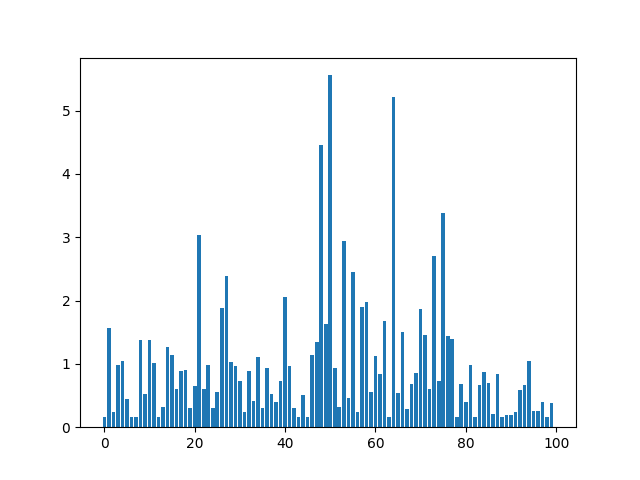

In [57]:
# You may wish to view the PageRank graphically.
# This code will draw a bar chart, for each (numbered) website on the generated internet,
# The height of each bar will be the score in the PageRank.
# Run this code to see the PageRank for each internet you generate.
# Hopefully you should see what you might expect
# - there are a few clusters of important websites, but most on the internet are rubbish!
%pylab notebook
r = pageRank(generate_internet(100), 0.9)
plt.bar(arange(r.shape[0]), r);